# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# filter all warnings
import warnings
warnings.filterwarnings("ignore")

# loads constants and helpers functions for readability
import helpers as h
import importlib      # to force module relaod 
h = importlib.reload(h)

import time

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import tpot

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

First, we will check if there are depulicates in both datasets. 

In [4]:
np.sum(azdias.duplicated()), np.sum(customers.duplicated())

(0, 0)

Cross check columns describes in documentation and available variables in the dataset

In [5]:
print("in documentation but not in Azdias dataset")
print("-"*15)
doc_not_azdias = []
for c in h.COLS_DOCUMENTATION:
    if c not in azdias.columns:
        doc_not_azdias.append(c)
print(doc_not_azdias)
print()
print("in Azdias dataset but not in documentation")
print("-"*15)
azdias_not_doc = []
for c in azdias.columns:
    if c not in h.COLS_DOCUMENTATION: 
        azdias_not_doc.append(c)
print(azdias_not_doc)

in documentation but not in Azdias dataset
---------------
['HAUSHALTSSTRUKTUR', 'D19_KK_KUNDENTYP', 'GEOSCORE_KLS7', 'WACHSTUMSGEBIET_NB', 'PLZ', 'KBA13_CCM_1400_2500', 'PLZ8', 'EINWOHNER', 'GKZ']

in Azdias dataset but not in documentation
---------------
['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_K

In [6]:
print("in documentation but not in Customers dataset")
print("-"*15)
doc_not_customers = []
for c in h.COLS_DOCUMENTATION:
    if c not in customers.columns:
        doc_not_customers.append(c)
print(doc_not_customers)
print()
print("in Customers dataset but not in documentation")
print("-"*15)
customers_not_doc = []
for c in customers.columns:
    if c not in h.COLS_DOCUMENTATION: 
        customers_not_doc.append(c)
print(customers_not_doc)

in documentation but not in Customers dataset
---------------
['HAUSHALTSSTRUKTUR', 'D19_KK_KUNDENTYP', 'GEOSCORE_KLS7', 'WACHSTUMSGEBIET_NB', 'PLZ', 'KBA13_CCM_1400_2500', 'PLZ8', 'EINWOHNER', 'GKZ']

in Customers dataset but not in documentation
---------------
['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER',

This function from the helper module, h.data_preparation, will perform the main steps of data cleaning and a bit of pre-processing (like one-hot encoding). Here are the processing steps that are taken on each columns that needs it. All the columns to be impacted by each step and the parameters of the transformation are given as constants in the helper module. 
1. remove the columns we don't want to keep
2. correct inconsistent values
3. check NA values as given in the documentation (i.e. GEBAEUDETYP -1, 0 > unknown)
4. copy columns 
5. perform mapping
6. one-hot encode categorical variables
7. reverse values order 
8. combine columns
9. drop columns (mostly highly correlated one) 

In [7]:
azdias = h.data_preparation(azdias)
azdias.shape

(891221, 366)
drop
...........! (891221, 358)
correct
...........! (891221, 358)
correct values
.....! (891221, 358)
convert nan values to nan
................................................................................................................................................................................................................................................................! (891221, 358)
duplicate
....! (891221, 362)
map
...........................................................! (891221, 362)
cat encoding
..............................! (891221, 501)
combine features
..............................................! (891221, 425)
drop
.........! (891221, 417)


(891221, 417)

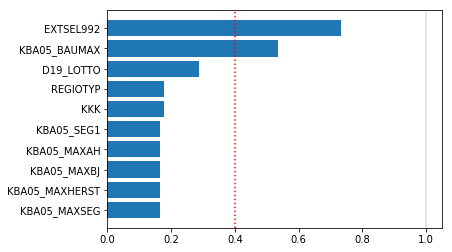

In [8]:
df_azidas_null = azdias.isnull().sum(axis=0).sort_values()
df_azidas_null = df_azidas_null / azdias.shape[0]
_ = plt.barh(df_azidas_null.index[-10:], df_azidas_null.values[-10:])
_ = plt.axvline(1.0, color="black", lw=0.2)
_ = plt.axvline(0.4, ls=":", color="red")

Check columns with too many NA values, add them in the "columns to drop" list. All columns with more than 40% data missing will be removed. 

In [9]:
cols_na = list(df_azidas_null[df_azidas_null>0.4].index)
cols_na

['KBA05_BAUMAX', 'EXTSEL992']

In [10]:
for c in cols_na: 
    if c in azdias.columns: 
        azdias.drop(columns=[c], inplace=True)

We will have a look at correlations between the variables. I've used the followings scripts to plot them before and have included them in the helper module. The data preparation function already removed the highly correlated one. The plot only shows the remaining correlation after the cleaning have been performed. 

In [10]:
# compute the correlation matrix
azdias_corr = azdias.corr()

In [11]:
# correlation absolute threshold value: 
# we will focus on pair of columns with correlation over this value  
threshold = 0.70
# remove the diagonal values (all 1)
for c in azdias_corr.columns:
    azdias_corr.loc[c,c] = np.nan
# filter the column names having at least 1 value over the threshold
cols_mask = ((azdias_corr.abs() > threshold).astype(np.int).max(axis=0)==1)
#reduce the matrix
azdias_corr = azdias_corr.loc[cols_mask, cols_mask]

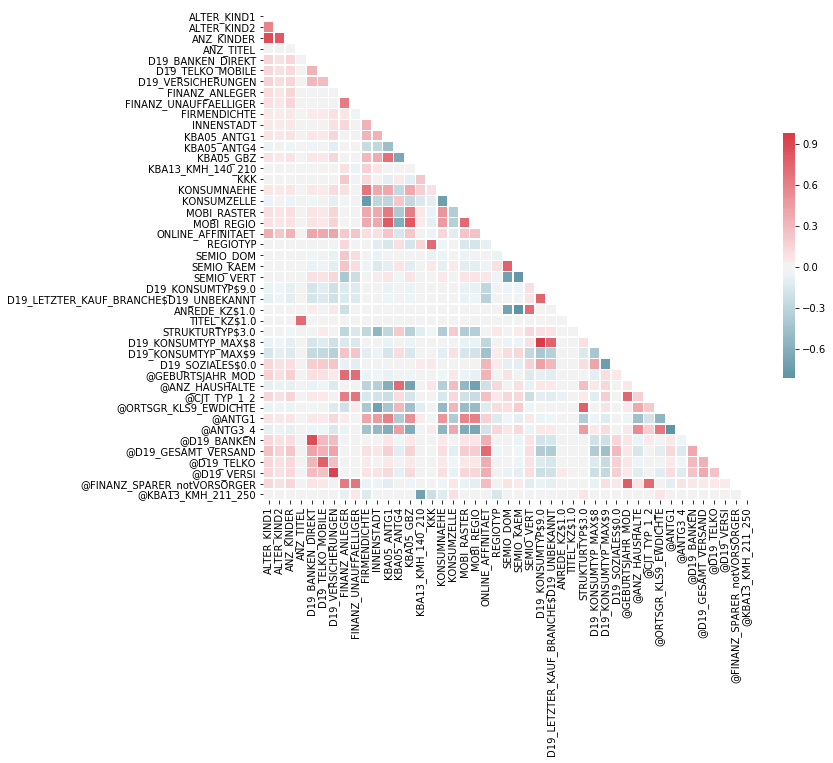

In [12]:
# Generate a mask for the upper triangle
mask = np.zeros_like(azdias_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(azdias_corr, mask=mask, cmap=cmap, center=0, #vmax=.3, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
del azdias_corr

We will drop rows where more than 10% of data are nan

In [11]:
rows_na = azdias.isnull().sum(axis=1).sort_values() / azdias.shape[1]
rows_na = list(rows_na[rows_na>0.1].index)
azdias = azdias.drop(rows_na)
azdias.shape, len(rows_na)

((737288, 415), 153933)

Load and prepare the customers data  

In [12]:
# we will keep the customer related data for analysis after customer segmentation
cols_customer_data = ["LNR", "PRODUCT_GROUP", "CUSTOMER_GROUP", "ONLINE_PURCHASE"]
customer_data = customers[cols_customer_data]

In [13]:
customers = h.data_preparation(customers)
customers.shape

(191652, 369)
drop
...........! (191652, 358)
correct
...........! (191652, 358)
correct values
.....! (191652, 358)
convert nan values to nan
................................................................................................................................................................................................................................................................! (191652, 358)
duplicate
....! (191652, 362)
map
...........................................................! (191652, 362)
cat encoding
..............................! (191652, 499)
combine features
..............................................! (191652, 423)
drop
.........! (191652, 415)


(191652, 415)

In [14]:
for c in cols_na: 
    if c in customers.columns: 
        customers.drop(columns=[c], inplace=True)
customers.shape

(191652, 413)

Let's check that we have consitent columns in both clean datasets.

In [15]:
azdias.shape, customers.shape
[c for c in customers.columns if c not in azdias.columns], [c for c in azdias.columns if c not in customers.columns]

for c in azdias.columns:
    if c not in customers.columns:
        customers[c] = np.nan
for c in customers.columns:
    if c not in azdias.columns:
        azdias[c] = np.nan


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Pre-processing

In [16]:
# as we will transform the panda data frame to numpy array later on, 
# we need to keep a list of columns names
azdias_columns = azdias.columns
customers_columns = customers.columns

First, let's check how many NaN values we have in the Azdias dataset. 

In [17]:
np.sum(np.isnan(azdias.values))

452628

We will now use scikit-learn imputation utilities to remove NaN

In [18]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(azdias)
azdias = imputer.transform(azdias)
customers = imputer.transform(customers)

Now, we will scale the values

In [19]:
transformer = MinMaxScaler((-1, 1))
transformer.fit(azdias)
azdias = transformer.transform(azdias)
customers = transformer.transform(customers)

In [20]:
azdias.shape, customers.shape

((737288, 415), (191652, 415))

### 1.2 Principal Component Analysis

In order to reduce the dimensions of the dataset to ease the work of the clustering algorithm, we perform a PCA on the dataset. We will keep enough components to explain 80% of the variance. 

In [21]:
# ratio of explained variance
ratio = 0.8

# computation of the pricnipal components
pca = PCA(n_components=ratio)
pca.fit(azdias)

# decomposation in principal components of both dataset
azdias_pca = pca.transform(azdias)
customers_pca = pca.transform(customers)

print("We will keep a ratio of {} of explained variance which results in {} components.".format(ratio, 
        len(pca.explained_variance_ratio_)))

We will keep a ratio of 0.8 of explained variance which results in 123 components.


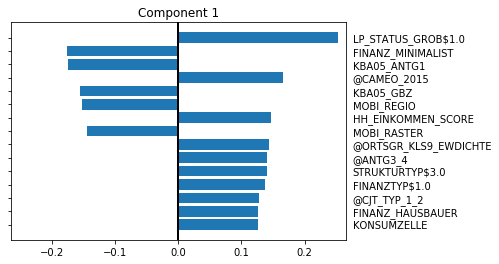

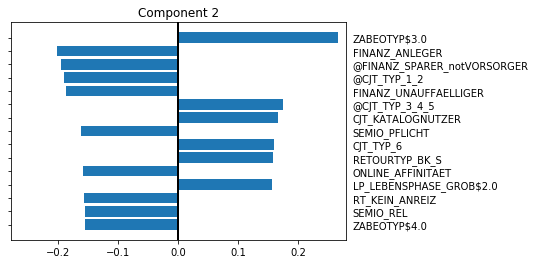

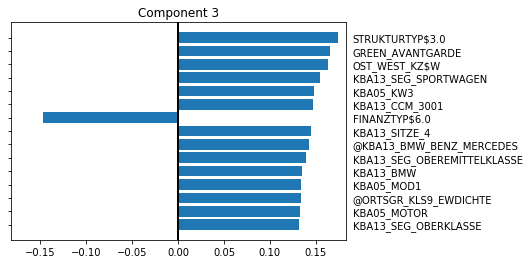

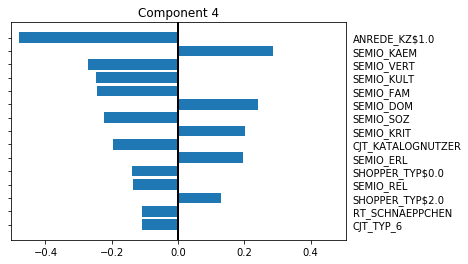

In [22]:
df_pca = pd.DataFrame()
df_pca["cols"] = azdias_columns
df_pca[0] = pca.components_[0]
df_pca[1] = pca.components_[1]
df_pca[2] = pca.components_[2]


def plot_pca_components(cols, components, title="", nb=15):
    cols_np = np.array(cols)
    comp_dict = {c:components[i] for i,c in enumerate(cols)}
    comp_dict = {k: v for k, v in sorted(comp_dict.items(), key=lambda item: np.abs(item[1]))}    
    names = list(comp_dict.keys())
    values = list(comp_dict.values())
    plt.barh(names[-nb:], values[-nb:])
    val_max = np.max(np.abs(values[-nb:]))*1.05
    plt.xlim(-val_max,val_max)
    plt.axvline(0.0, color="black", lw=2)
    plt.title(title)
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
    plt.show()

plot_pca_components(azdias_columns, pca.components_[0], "Component 1")    
plot_pca_components(azdias_columns, pca.components_[1], "Component 2")    
plot_pca_components(azdias_columns, pca.components_[2], "Component 3")
plot_pca_components(azdias_columns, pca.components_[3], "Component 4")

### 1.3 K-Means clustering

I've chosen the K-Means clustering 
The first step is to choose the value of K. We apply perform

In [26]:
start_time = time.time()
scores, distances = [], []
range_n_clusters = range(2,20)
for n_clusters in range_n_clusters:
    # create and fit model for K 
    clustering = KMeans (n_clusters=n_clusters, n_jobs=-1).fit(azdias_pca)
    # retrieve the centers 
    centers = clustering.cluster_centers_
    # compute score 
    score = clustering.score(azdias_pca) / azdias_pca.shape[0]
    scores.append(score)
    # compute distance mean to center 
    preds = clustering.predict(azdias_pca)
    centers = centers[preds]
    distance = np.sqrt(((azdias_pca-centers)**2).sum(axis=1)).mean()
    distances.append(distance)
    print ("{: 7.2f} n_clusters={:02d} score={:.04f} dist.={:.04f}".format(
        (time.time()-start_time)/60, n_clusters, score, distance))

   0.41 n_clusters=02 score=-94.2610 dist.=9.6854
   1.15 n_clusters=03 score=-91.1415 dist.=9.5234
   2.21 n_clusters=04 score=-88.9490 dist.=9.4081
   3.68 n_clusters=05 score=-87.5286 dist.=9.3319
   5.67 n_clusters=06 score=-86.4296 dist.=9.2740
   7.90 n_clusters=07 score=-85.4867 dist.=9.2227
  10.85 n_clusters=08 score=-84.6760 dist.=9.1789
  13.93 n_clusters=09 score=-84.0170 dist.=9.1432
  17.29 n_clusters=10 score=-83.3751 dist.=9.1074
  20.91 n_clusters=11 score=-82.7908 dist.=9.0760
  25.12 n_clusters=12 score=-82.2553 dist.=9.0462
  29.24 n_clusters=13 score=-81.8019 dist.=9.0212
  33.58 n_clusters=14 score=-81.3462 dist.=8.9957
  38.58 n_clusters=15 score=-80.9862 dist.=8.9757
  43.50 n_clusters=16 score=-80.5891 dist.=8.9529
  48.77 n_clusters=17 score=-80.1990 dist.=8.9310
  54.58 n_clusters=18 score=-79.8633 dist.=8.9119
  60.91 n_clusters=19 score=-79.6105 dist.=8.8975


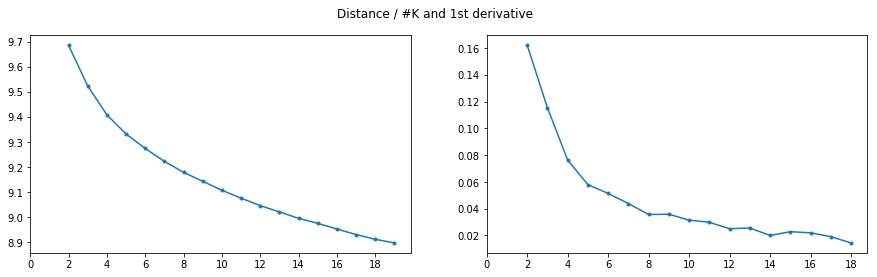

In [27]:
# we will plot the distance agaisnt the number of K
# in order to help us, we will also compute and plot the difference 
# for a K with the previous K  
derivative = [c-distances[1:][i] for i,c in enumerate(distances[:-1])]

# create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('Distance / #K and 1st derivative')
ax1.plot([None,None] + distances, marker=".")
ax2.plot([None,None] + derivative, marker=".")

ax1.set_xticks(np.arange(0, 20, 2))
ax2.set_xticks(np.arange(0, 20, 2))
plt.show()


The choice is not easy, we could take a value between 5 and 8. I've chosen the value of 8 as it seems it is the last value before the change distance starts to be more flat. Let's fit the K-Means model withthe global Azdias dataset. We will the transform both Azdias and customers datasets to analyse and compare clusters for both. 

In [23]:
# create clustering with K-means with K = 8
n_clusters = 8
clustering = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=42)
clustering.fit(azdias_pca)
preds_a = clustering.predict(azdias_pca)
preds_c = clustering.predict(customers_pca)

In [95]:
# create a bar plot with labels
def create_bar_plot(x, y, label, ax, offsets=(0,0)):
    sns.barplot(x=x, y=y, palette="vlag", ax=ax)
    ax.axhline(0, color="k", clip_on=False)
    ax.set_ylabel(label)
    for i,p in enumerate(ax.patches):
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + offsets[0]
        value = "{:.01f}%".format(y[i])
        ax.text(_x, _y + offsets[1], value, ha="center") 


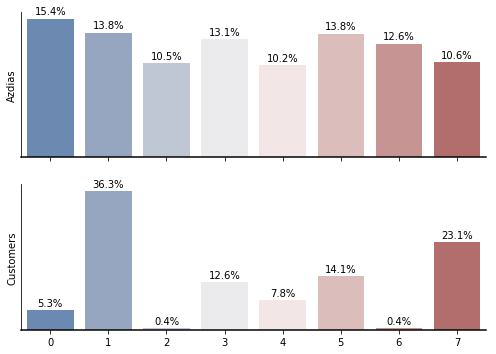

In [107]:
# Generate the figure and the index data
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
x = np.array([c for c in range(n_clusters)])

# plot the distribution of the Azdias dataset over the clusters
pct = np.unique(preds_a, return_counts=True)[1] / np.sum(np.unique(preds_a, return_counts=True)[1])*100.0
create_bar_plot(x, pct, "Azdias", ax1, offsets=(0,0.5))

# plot the distribution of the Customer dataset over the clusters
y2 = [0 for c in range(n_clusters)]
for i,idx in enumerate(np.unique(preds_c, return_counts=True)[0]):
    y2[idx] = np.unique(preds_c, return_counts=True)[1][i]
pct = y2 / np.sum(np.unique(preds_c, return_counts=True)[1])*100.0
create_bar_plot(x, pct, "Customers", ax2, offsets=(0,1))

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

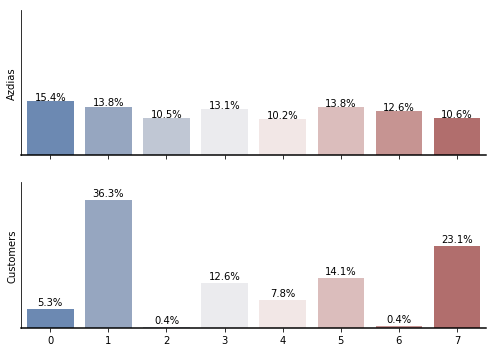

In [24]:
# Generate the figure and the index data
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
x = np.array([c for c in range(n_clusters)])

# plot the distriubtion of the Azdias dataset over the clusters
y1 = np.unique(preds_a, return_counts=True)[1]
sns.barplot(x=x, y=y1, palette="vlag", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Azdias")
ax1.set_ylim(0,preds_a.shape[0]//n_clusters*3.3)

#write the percentage value on top of each bar
pct = np.unique(preds_a, return_counts=True)[1] / np.sum(np.unique(preds_a, return_counts=True)[1])*100.0
for i,p in enumerate(ax1.patches):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 2000
    value = "{:.01f}%".format(pct[i])
    ax1.text(_x, _y+12, value, ha="center") 

# plot the distriubtion of the Customers dataset over the clusters
y2 = [0 for c in range(n_clusters)]
for i,idx in enumerate(np.unique(preds_c, return_counts=True)[0]):
    y2[idx] = np.unique(preds_c, return_counts=True)[1][i]
sns.barplot(x=x, y=y2, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Customers")
ax2.set_ylim(0,preds_c.shape[0]//n_clusters*3.3)

#write the percentage value on top of each bar
pct = y2 / np.sum(np.unique(preds_c, return_counts=True)[1])*100.0
for i,p in enumerate(ax2.patches):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height()  + 2000 
    value = "{:.01f}%".format(pct[i])
    ax2.text(_x, _y+12, value, ha="center") 

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [33]:
clustering.cluster_centers_[0]
df = pd.DataFrame()
df["cols"] = azdias_columns
df["eval"] = 0.0
df["ref"] = np.mean(transformer.inverse_transform(azdias), axis=0)
df["std"] = np.std(transformer.inverse_transform(azdias), axis=0)
df["min"] = np.min(transformer.inverse_transform(azdias), axis=0)
df["max"] = np.max(transformer.inverse_transform(azdias), axis=0)
for i,c in enumerate(clustering.cluster_centers_):
    df[i] = transformer.inverse_transform(pca.inverse_transform(c.reshape(1, -1)))[0,:]
    df["eval"+str(i)] = (df[i]-df["ref"])/df["std"]
df["eval"] = df[["eval"+str(i) for i in range(0, n_clusters)]].abs().max(axis=1)
df.sort_values(by="eval", ascending=False).head(10)

,cols,eval,ref,std,min,max,0,eval0,1,eval1,...,3,eval3,4,eval4,5,eval5,6,eval6,7,eval7
56,GREEN_AVANTGARDE,1.374408,0.223591,0.416651,0.0,1.000000,0.022180,-0.483404,0.796240,1.374408,...,0.075358,-0.355773,0.168471,-0.132293,0.377498,0.369390,0.033420,-0.456428,0.162129,-0.147515
53,FINANZ_MINIMALIST,1.349617,3.039552,1.381531,1.0,5.000000,2.887378,-0.110148,4.402432,0.986501,...,4.356119,0.952977,2.841229,-0.143553,3.667185,0.454303,1.175014,-1.349617,2.458970,-0.420245
300,LP_STATUS_GROB$5.0,1.327423,0.142006,0.349056,0.0,1.000000,0.013355,-0.368569,0.605350,1.327423,...,0.086850,-0.158013,0.020272,-0.348750,0.262964,0.346530,0.000406,-0.405665,0.049868,-0.263963
188,SEMIO_FAM,1.310053,4.113865,1.895227,1.0,7.000000,3.332228,-0.412424,3.601965,-0.270099,...,3.466427,-0.341615,4.281758,0.088587,4.139974,0.013777,3.718773,-0.208467,4.546264,0.228152
383,@D19_GESAMT_VERSAND,1.307337,1.675060,2.167800,0.0,6.888889,0.843912,-0.383406,1.830549,0.071727,...,1.200681,-0.218830,0.933460,-0.342098,4.509104,1.307337,1.647011,-0.012939,0.634504,-0.480006
381,@BAUMAX_BUSINESS,1.274467,0.147728,0.354830,0.0,1.000000,0.118477,-0.082435,0.025939,-0.343232,...,0.006849,-0.397031,0.599947,1.274467,0.011280,-0.384545,0.267423,0.337332,0.007240,-0.395931
191,SEMIO_KULT,1.273363,4.168812,1.942195,1.0,7.000000,3.163578,-0.517576,3.618708,-0.283238,...,3.493573,-0.347668,4.008778,-0.082398,4.501387,0.171237,3.910742,-0.132875,4.776572,0.312924
263,FINANZTYP$1.0,1.268275,0.248570,0.432184,0.0,1.000000,0.046908,-0.466612,0.019314,-0.530460,...,-0.000604,-0.576547,0.151190,-0.225321,0.145645,-0.238152,0.796699,1.268275,0.443472,0.450968
175,KONSUMZELLE,1.245012,0.236939,0.425204,0.0,1.000000,0.182017,-0.129166,0.107791,-0.303731,...,0.065510,-0.403168,0.766323,1.245012,0.076856,-0.376483,0.374054,0.322471,0.097596,-0.327708
179,ONLINE_AFFINITAET,1.244171,2.716507,1.541528,0.0,5.000000,1.495541,-0.792049,2.814230,0.063393,...,2.219040,-0.322711,1.844170,-0.565891,4.634431,1.244171,3.071164,0.230068,2.678749,-0.024494


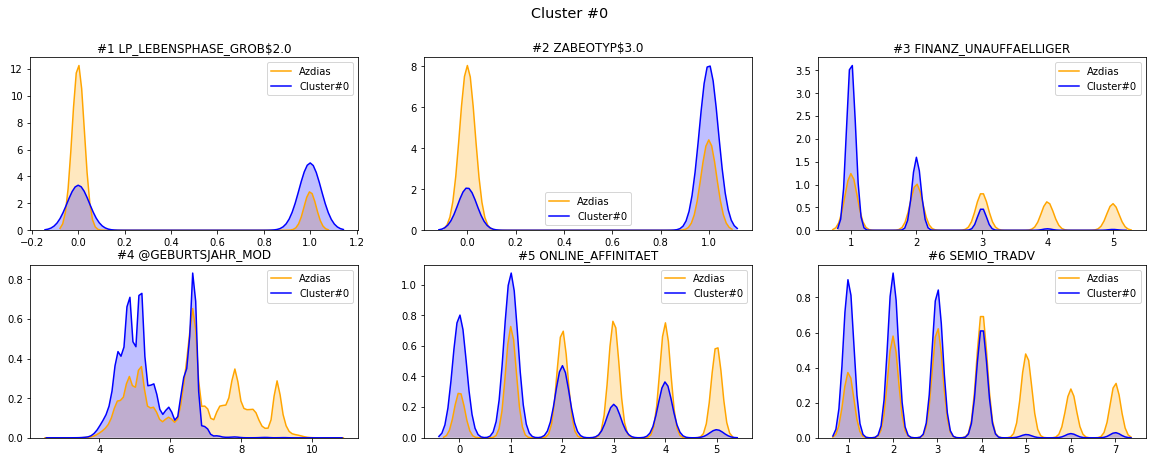

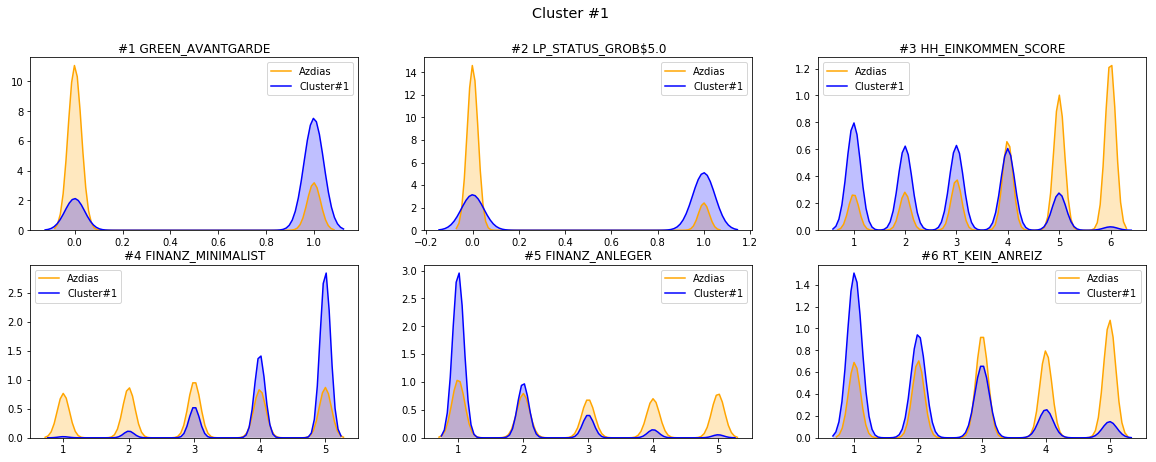

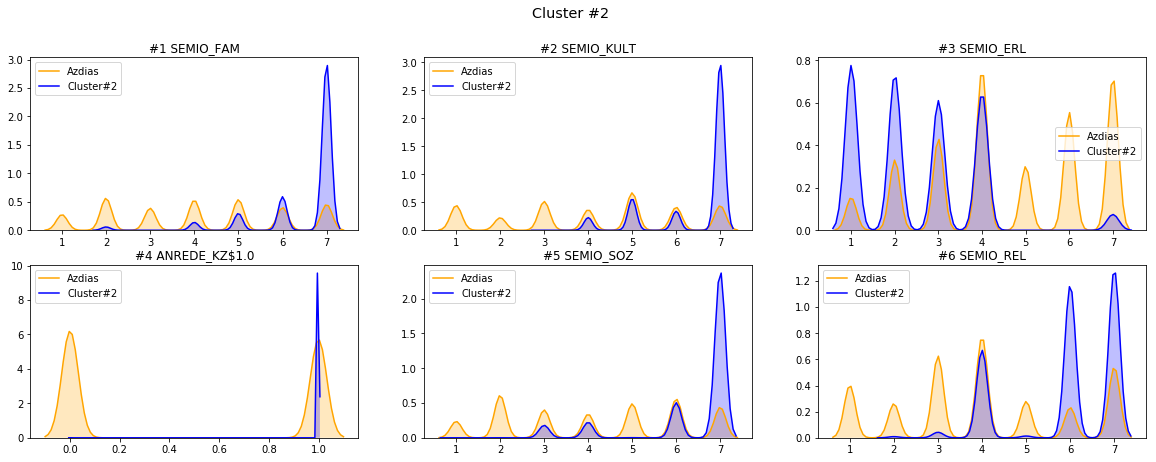

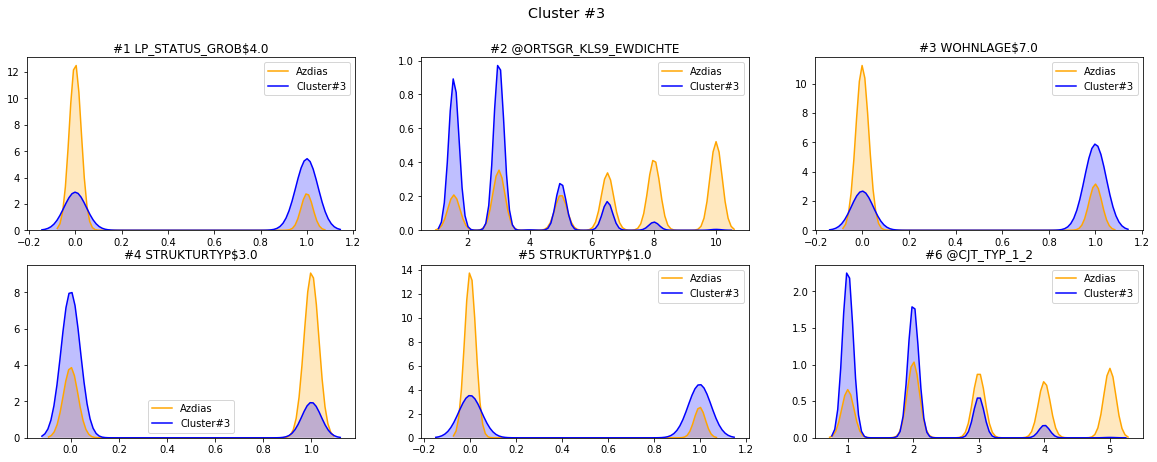

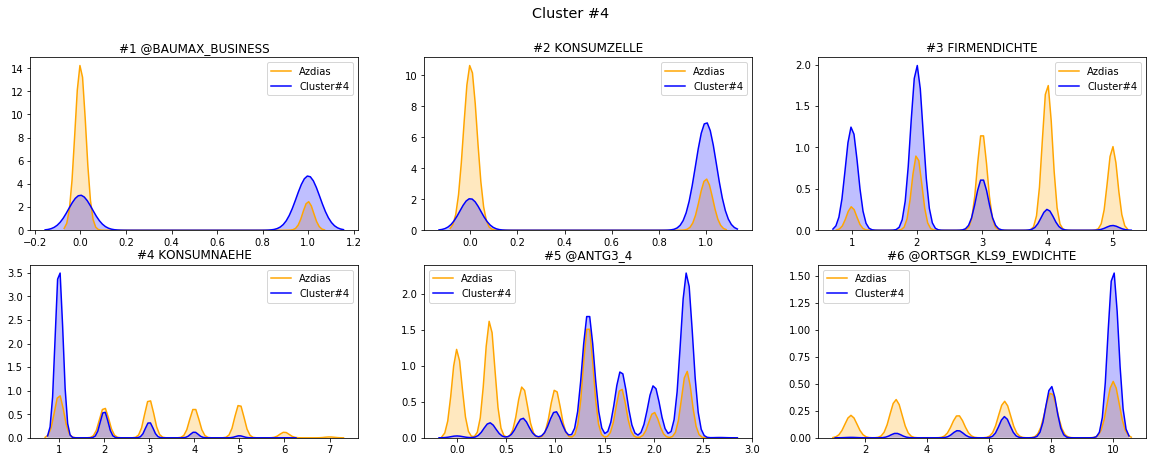

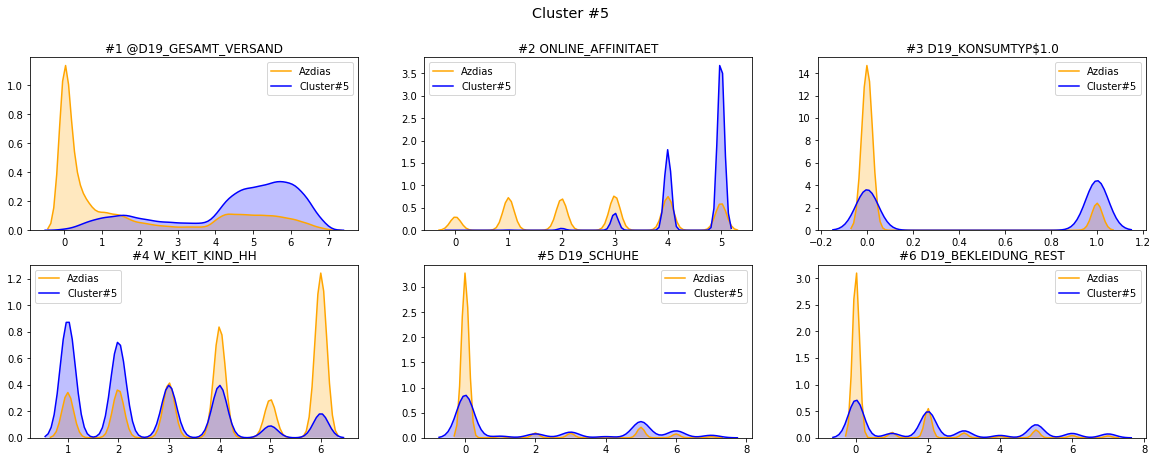

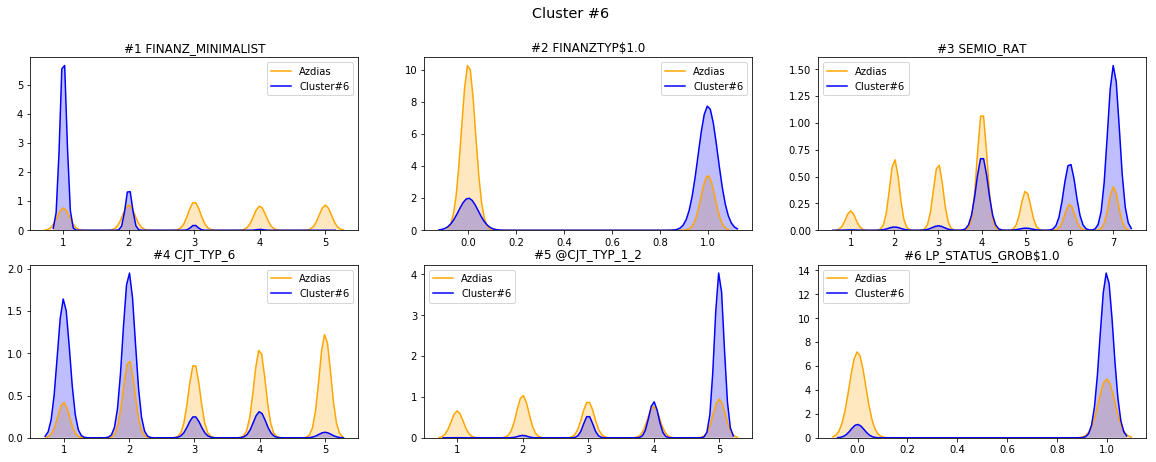

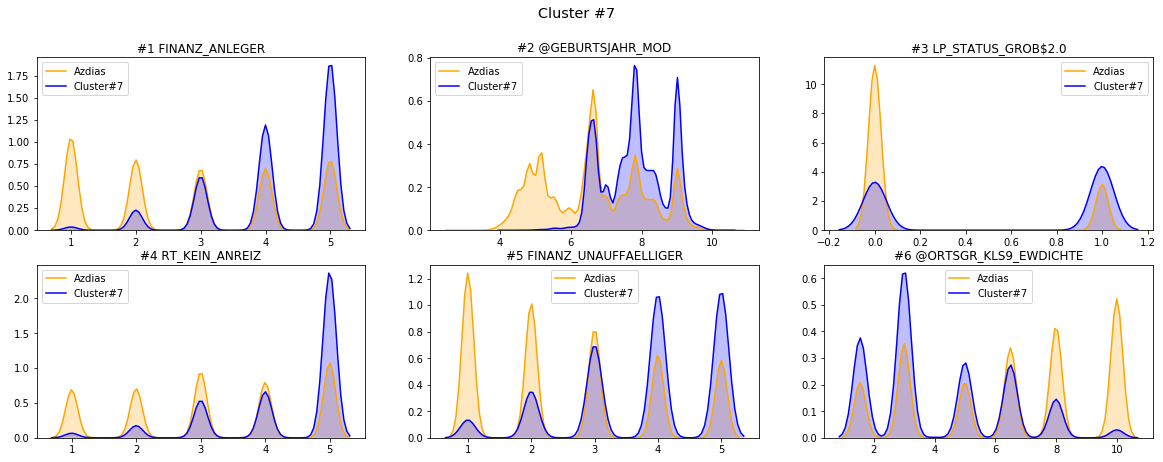

In [26]:
# display the most representative features for each cluster
for cluster_no in range(n_clusters):
    # reference : aboslute value of the eval column of the given cluster  
    df["evalcol"] = df["eval"+str(cluster_no)].abs()
    df_tmp = df.sort_values(by="evalcol", ascending=False).head(6)
    cluster_cols = list(df_tmp["cols"].values)
    f, axes = plt.subplots(2, 3, figsize=(20, 7), sharex=False)
    st = f.suptitle("Cluster #"+str(cluster_no), fontsize="x-large")
    for i in range(6):
        a, b = i // 3, i % 3
        ax = axes[a, b]
        idx = list(azdias_columns).index(cluster_cols[i])
        # plot the distribution for the whole Azdias dataset  
        sns.distplot(transformer.inverse_transform(azdias)[:,idx], 
                     hist=False, kde=True, rug=False, 
                     color="orange", kde_kws={"shade": True}, 
                     label="Azdias", ax=ax)
        # plot the distribution for the cluster  
        sns.distplot(transformer.inverse_transform(azdias)[(preds_a==cluster_no),idx], 
                     hist=False, kde=True, rug=False, 
                     color="blue", kde_kws={"shade": True}, 
                     label="Cluster#"+str(cluster_no), ax=ax)
        ax.title.set_text("#"+str(i+1)+" "+cluster_cols[i])
        ax.grid([])
        ax.legend()
    plt.show()

In [27]:
# create segment names with the 2 first representative features 
seg_names = []
for i in range(n_clusters):
    df["evalcol"] = df["eval"+str(i)].abs()
    seg_name = "_".join(list(df.sort_values(by="evalcol", ascending=False).head(2)["cols"]))
    print(i, seg_name)
    seg_names.append(seg_name)

0 LP_LEBENSPHASE_GROB$2.0_ZABEOTYP$3.0
1 GREEN_AVANTGARDE_LP_STATUS_GROB$5.0
2 SEMIO_FAM_SEMIO_KULT
3 LP_STATUS_GROB$4.0_@ORTSGR_KLS9_EWDICHTE
4 @BAUMAX_BUSINESS_KONSUMZELLE
5 @D19_GESAMT_VERSAND_ONLINE_AFFINITAET
6 FINANZ_MINIMALIST_FINANZTYP$1.0
7 FINANZ_ANLEGER_@GEBURTSJAHR_MOD


In [28]:
#compute customer data 
customer_data["cluster"] = preds_c
customer_data["Food"] = 0.0
customer_data["Cosmetic"] = 0.0
customer_data["All"] = 0.0
customer_data.loc[customer_data["PRODUCT_GROUP"]=="FOOD", "Food"] = 1.0
customer_data.loc[customer_data["PRODUCT_GROUP"]=="COSMETIC", "Cosmetic"] = 1.0
customer_data.loc[customer_data["PRODUCT_GROUP"]=="COSMETIC_AND_FOOD", "All"] = 1.0
customer_data

,LNR,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,cluster,Food,Cosmetic,All
0,9626,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,0.0,0.0,1.0
1,9628,FOOD,SINGLE_BUYER,0,3,1.0,0.0,0.0
2,143872,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,0.0,0.0,1.0
3,143873,COSMETIC,MULTI_BUYER,0,3,0.0,1.0,0.0
4,143874,FOOD,MULTI_BUYER,0,4,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
191647,154561,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,0.0,0.0,1.0
191648,154563,COSMETIC,SINGLE_BUYER,0,3,0.0,1.0,0.0
191649,148813,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,0.0,0.0,1.0
191650,148852,FOOD,SINGLE_BUYER,0,5,1.0,0.0,0.0


In [29]:
# add the prediction to the customer data
customer_data["cluster"] = preds_c
x = np.array([c for c in range(n_clusters)])
y = [np.sum(customer_data["cluster"]==c) for c in x]
print(y)

#calculate percentages for each cluster
y1 = [np.sum(customer_data[customer_data["cluster"]==c]["ONLINE_PURCHASE"])/d*100.0 for c,d in zip(x,y)] 
y2 = [np.sum(customer_data[customer_data["cluster"]==c]["CUSTOMER_GROUP"]=="MULTI_BUYER")/d*100.0 for c,d in zip(x,y)] 
y3 = [np.sum(customer_data[customer_data["cluster"]==c]["PRODUCT_GROUP"]=="FOOD")/d*100.0 for c,d in zip(x,y)] 
y4 = [np.sum(customer_data[customer_data["cluster"]==c]["PRODUCT_GROUP"]=="COSMETIC")/d*100.0 for c,d in zip(x,y)]
y5 = [np.sum(customer_data[customer_data["cluster"]==c]["PRODUCT_GROUP"]=="COSMETIC_AND_FOOD")/d*100.0 for c,d in zip(x,y)]


[10141, 69503, 695, 24226, 15010, 27050, 761, 44266]


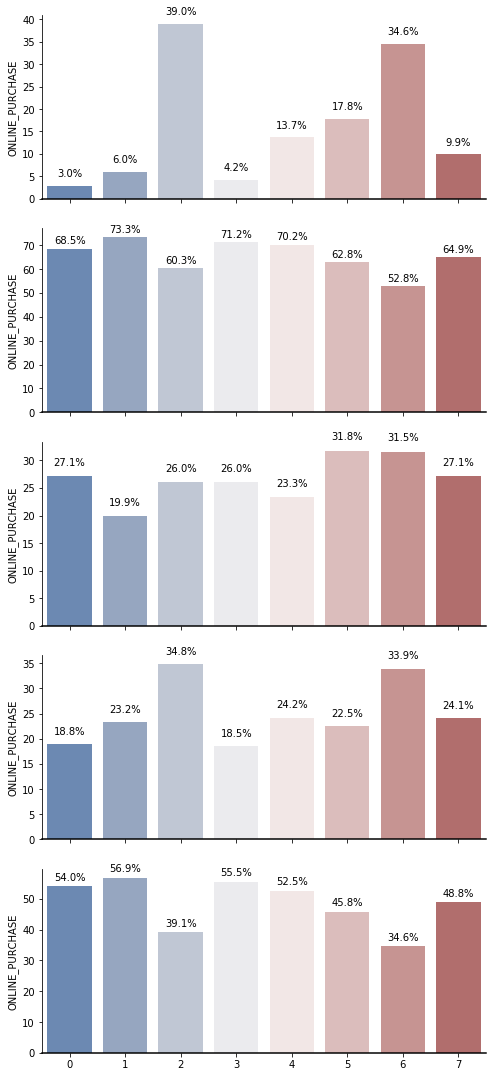

In [97]:
# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(7, 15), sharex=True)

# Generate some sequential data
x = np.array([c for c in range(n_clusters)])

create_bar_plot(x, y1, "ONLINE_PURCHASE", ax1, offsets=(-10,12))
create_bar_plot(x, y2, "ONLINE_PURCHASE", ax2, offsets=(-10,12))
create_bar_plot(x, y3, "ONLINE_PURCHASE", ax3, offsets=(-10,12))
create_bar_plot(x, y4, "ONLINE_PURCHASE", ax4, offsets=(-10,12))
create_bar_plot(x, y5, "ONLINE_PURCHASE", ax5, offsets=(-10,12))

# Finalize the plot
sns.despine(bottom=True)
# plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [ ]:
del azdias
del azdias_pca
del customers
del customers_pca

In [37]:
# https://stackoverflow.com/questions/24455615/python-how-to-display-size-of-all-variables

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:15]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        azdias:  2.3 GiB
                    azdias_pca: 691.9 MiB
                     customers: 606.8 MiB
                 customers_pca: 179.8 MiB
                 customer_data: 33.1 MiB
                       preds_a:  2.8 MiB
                       rows_na:  1.3 MiB
                       preds_c: 748.7 KiB
                            df: 104.3 KiB
                df_azidas_null: 56.3 KiB
                azdias_columns: 52.8 KiB
                           _28: 52.6 KiB
             customers_columns: 50.4 KiB
                        df_pca: 42.7 KiB
                        df_tmp: 13.7 KiB


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1 Data preparation & features creation

In [34]:
#load the dataset
df_mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

#check duplicates
cols_duplicates = list(df_mailout_train.columns)
cols_duplicates.remove("LNR")
cols_duplicates.remove("RESPONSE")
print("Number of duplicated", df_mailout_train.duplicated(subset=cols_duplicates).sum())

# remove columns as for the azdias dataset
for c in cols_na: 
    if c in df_mailout_train.columns: 
        df_mailout_train.drop(columns=[c], inplace=True)
df_mailout_train.shape

Number of duplicated 5767


(42962, 365)

In [35]:
rows_na = df_mailout_train.isnull().sum(axis=1).sort_values() / df_mailout_train.shape[1]
rows_na = list(rows_na[rows_na>0.65].index)
label1 = list(df_mailout_train[df_mailout_train["RESPONSE"]==1].index)
rows_na = [r for r in rows_na if r not in label1]
print("number of rows with more of 65% missing values", len(rows_na))
# df_mailout_train = df_mailout_train.drop(rows_na)

# keep the labels
label = df_mailout_train.RESPONSE
del df_mailout_train["RESPONSE"]
print(df_mailout_train.shape)

number of rows with more of 65% missing values 6904
(42962, 364)


In [36]:
# prepare the data from the mail train datast
df_mailout_train = h.data_preparation(df_mailout_train)
# add missing columns if any
missing_cols = [c for c in azdias_columns if c not in df_mailout_train.columns]
missing_cols = missing_cols + [c for c in customers_columns if c not in df_mailout_train.columns]
missing_cols = list(set(missing_cols))
for c in missing_cols:
    print(c)
    df_mailout_train[c] = np.nan
print(df_mailout_train.shape)

(42962, 364)
drop
...........! (42962, 356)
correct
...........! (42962, 356)
correct values
.....! (42962, 356)
convert nan values to nan
................................................................................................................................................................................................................................................................! (42962, 356)
duplicate
....! (42962, 360)
map
...........................................................! (42962, 360)
cat encoding
..............................! (42962, 497)
combine features
..............................................! (42962, 421)
drop
.........! (42962, 413)
GEBAEUDETYP$5.0
TITEL_KZ$2.0
(42962, 415)


In [37]:
# calculate PCA for clustering
mailout_train_pca = transformer.transform(df_mailout_train.values)
mailout_train_pca = imputer.transform(mailout_train_pca)
mailout_train_pca = pca.transform(mailout_train_pca)
print("size of pca for clustering", mailout_train_pca.shape)

# find the clusters for each mail train prospect 
clusters_mailout_train = clustering.predict(mailout_train_pca)

#perform one-hot encoding to add the custer number to the dataframe
one_hot_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
one_hot_enc.fit(clusters_mailout_train.reshape(-1,1))
clusters_mailout_train_data = one_hot_enc.transform(clusters_mailout_train.reshape(-1,1))

for i in range(n_clusters):
    df_mailout_train["~Cluster_"+seg_names[i]] = clusters_mailout_train_data[:,i]
df_mailout_train.shape

size of pca for clustering (42962, 123)


(42962, 423)

In [38]:
# compute distance to centroids and add it to the dataframe 
for i, center in enumerate(clustering.cluster_centers_):
    distance = np.sqrt((mailout_train_pca-center)**2).sum(axis=1)
    df_mailout_train["~Distance_"+seg_names[i]] = distance.reshape(-1,1)

mailout_train_columns = list(df_mailout_train.columns)
df_mailout_train.shape  

(42962, 431)

In [39]:
# instanciante the scaler and the imputer
scaler_mail = StandardScaler()
imputer_mail = KNNImputer(missing_values=np.nan, n_neighbors=3)

# scale
scaler_mail.fit(df_mailout_train.values)
mailout_train = scaler_mail.transform(df_mailout_train.values)

# imputation based on a subsample of data
train_idx = [i for i in range(df_mailout_train.shape[0])]
np.random.shuffle(train_idx)
imputer_mail.fit(mailout_train[train_idx[:len(train_idx)//4],:])
mailout_train = imputer_mail.transform(mailout_train)

In [40]:
# columns in the dataset for later use
missing_cols = list(df_mailout_train.columns[df_mailout_train.isna().sum(axis=0)==df_mailout_train.shape[0]])
mailout_train_columns = [c for c in mailout_train_columns if c not in missing_cols]

In [41]:
mailout_train.shape, np.min(mailout_train), np.mean(mailout_train), np.max(mailout_train) 

((42962, 429), -34.79441197674574, -0.004488537235516642, 92.68980526465677)

In [42]:
# summaroze the groups of columns
cluster_cols  = [c for c in mailout_train_columns if c[:8]=="~Cluster" ]
distance_cols = [c for c in mailout_train_columns if c[:9]=="~Distance" ]
origin_cols   = [c for c in mailout_train_columns if c not in cluster_cols and c not in distance_cols]

# compute the PCA for the mail train
pca_mail = PCA(n_components=0.8)
pca_mail.fit(mailout_train)
mailout_train_pca_mail = pca_mail.transform(mailout_train)

In [43]:
len(mailout_train_columns), mailout_train.shape, mailout_train_pca_mail.shape

(429, (42962, 429), (42962, 172))

### 2.2 Benchmark models

In [44]:
def test_model(m, folds, X, y, verbose=True):
    np.random.seed(6677)
    scores, exe_times = [], []
    # loop throught the sets of the different folds
    for train_index, test_index in folds.split(X, y):
        if verbose:print(".", end="")
        start_time = time.time()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # fit the model
        m.fit(X_train, y_train)
        # predict and score the model
        y_pred = m.predict_proba(X_test)
        score = roc_auc_score(y_test, y_pred[:,1])
        scores.append(score)
        exe_times.append(time.time()-start_time)
    #verbose mode: display the results
    if verbose:
        print(end="\r")
        print("Mean area under ROC curve : {:4.3f} (standard dev. {:4.3f}) in {:4.1f} s. per model".format(
                np.mean(scores), np.std(scores), np.mean(exe_times)))
    return scores, exe_times

In [45]:
n_splits = 5

In [46]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_base_0 = LogisticRegression(C=10.0, dual=False, penalty="l2", max_iter=1400, n_jobs=-1)
scores, times = test_model(model_base_0, folds, mailout_train[:,], label.values)
model_base_0 = model_base_0.fit(mailout_train[:,], label.values)

Mean area under ROC curve : 0.715 (standard dev. 0.012) in 59.4 s. per model


In [47]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_base_0_pca = LogisticRegression(C=10.0, dual=False, penalty="l2", max_iter=1400, n_jobs=-1)
scores, times = test_model(model_base_0_pca, folds, mailout_train_pca_mail[:,], label.values)
model_base_0_pca = model_base_0_pca.fit(mailout_train_pca_mail[:,], label.values)

Mean area under ROC curve : 0.740 (standard dev. 0.016) in  6.2 s. per model


In [74]:
# out-of-the-box parameters for XGBoost Classifier
p_XGB0 = {
 'learning_rate': 0.1,
 'n_estimators': 100,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'random_state': 42,
 'seed': 42,
 'eval_metric': 'auc'}

In [49]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

model_base_xgb_0 = XGBClassifier(**p_XGB0)
scores, times = test_model(model_base_xgb_0, folds, mailout_train, label.values)
model_base_xgb_0 = model_base_xgb_0.fit(mailout_train[:,], label.values)

Mean area under ROC curve : 0.756 (standard dev. 0.017) in  6.8 s. per model


In [50]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_base_xgb_0_pca = XGBClassifier(**p_XGB0)
scores, times = test_model(model_base_xgb_0_pca, folds, mailout_train_pca_mail[:,], label.values)
model_base_xgb_0_pca = model_base_xgb_0_pca.fit(mailout_train_pca_mail[:,], label.values)

Mean area under ROC curve : 0.700 (standard dev. 0.012) in  8.9 s. per model


### 2.3 Feature selection

In [55]:
# SelectKBest is a feature selection tool implemented in Scikit-Learn
# It looks for features correlated with the label
# A k number of features can be specified, I specified "all"
Kbest = SelectKBest(k = "all")
Kbest.fit(mailout_train[:,], label.values)

# creation of a dataframe with the best features
kbest_features = np.array(mailout_train_columns)[Kbest.get_support()]
df_tmp = pd.DataFrame()
df_tmp["feature"] = kbest_features
df_tmp["score"] = Kbest.scores_[Kbest.get_support()]
df_tmp.sort_values("score", ascending=False).head(20)

,feature,score
362,D19_SOZIALES$1.0,573.316453
351,D19_KONSUMTYP_MAX$2,234.515713
354,D19_KONSUMTYP_MAX$8,92.092284
361,D19_SOZIALES$0.0,91.042635
364,D19_SOZIALES$3.0,83.445996
212,D19_KONSUMTYP$3.0,62.917429
216,D19_KONSUMTYP$9.0,55.230212
184,RT_SCHNAEPPCHEN,43.169418
365,D19_SOZIALES$4.0,21.028620
350,D19_KONSUMTYP_MAX$1,19.366342


We can see that 2 features are really weighing a lot more than other : `D19_SOZIALES$1.0` and `D19_KONSUMTYP_MAX$2`. Both are not documented and have treated as categorical data. We can see that other categories extracted from the original `D19_SOZIALES` and `D19_KONSUMTYP_MAX` are also widely represented in the top 10.

In [61]:
# create a features dictionnary and with name of feature and score 
cols_np = np.array(mailout_train_columns)
features_dict = {}
for i in range(cols_np.shape[0]):
    features_dict[cols_np[i]] = Kbest.scores_[i] #Kbest.pvalues_[i]

# sort the dictionary and store key & value in descending oredered lists
names, values = [], []
for k, v in sorted(features_dict.items(), key=lambda item: -item[1]):
    names.append(k)
    values.append(v)

Here we will try different values of the K best features to keep and evaluate how our models behave for each size. 

In [62]:
# create a dataframe to keep the experiment values 
data_fs = [pd.DataFrame(columns=["n_features","iteration","auc","auc_std","time"])]*2

# loop for different K value
for i in range(5, 400, 4):
    
    # create the feature mask for the k best feature 
    kbest_features = names[:i]
    kbest_features_mask = np.isin(np.array(mailout_train_columns), kbest_features)

    # create a fold generator  
    np.random.seed(1974)
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # instanciante models to be tests and loop on them
    m1 = LogisticRegression(n_jobs=-1)
    m2 = XGBClassifier(**p_XGB0)
    for j,m in enumerate([m1,m2]): 
        start_time = time.time()
        np.random.seed(6677)
        # cross validate and gather eperiment data
        scores = cross_validate(m, mailout_train[:,kbest_features_mask], label.values, 
                                scoring=["roc_auc"], n_jobs=-1, 
                                cv=folds, return_train_score=False)
        scores_roc_auc = list(scores["test_roc_auc"])
        data_fs[j] = data_fs[j].append({"n_features":i, "auc":np.mean(scores_roc_auc), 
                                        "auc_std":np.std(scores_roc_auc), 
                                        "time":time.time()-start_time}, ignore_index=True)

        # verbose mode
        if (i//4)%10 == 0:
            print("{:3d} {:d} {:4.3f} {:4.3f} {:4.3f}".format(i, j, 
                                                  np.mean(scores_roc_auc), 
                                                  np.std(scores_roc_auc), 
                                                  time.time()-start_time))


 41 0 0.771 0.018 1.402
 41 1 0.761 0.019 6.245
 81 0 0.770 0.012 1.827
 81 1 0.765 0.012 11.240
121 0 0.768 0.011 2.566
121 1 0.767 0.018 16.405
161 0 0.764 0.006 3.557
161 1 0.770 0.018 21.178
201 0 0.758 0.007 4.237
201 1 0.772 0.020 26.382
241 0 0.752 0.007 5.873
241 1 0.766 0.019 32.689
281 0 0.740 0.013 7.715
281 1 0.763 0.020 38.173
321 0 0.734 0.015 6.367
321 1 0.766 0.020 44.482
361 0 0.726 0.012 9.186
361 1 0.762 0.020 47.381


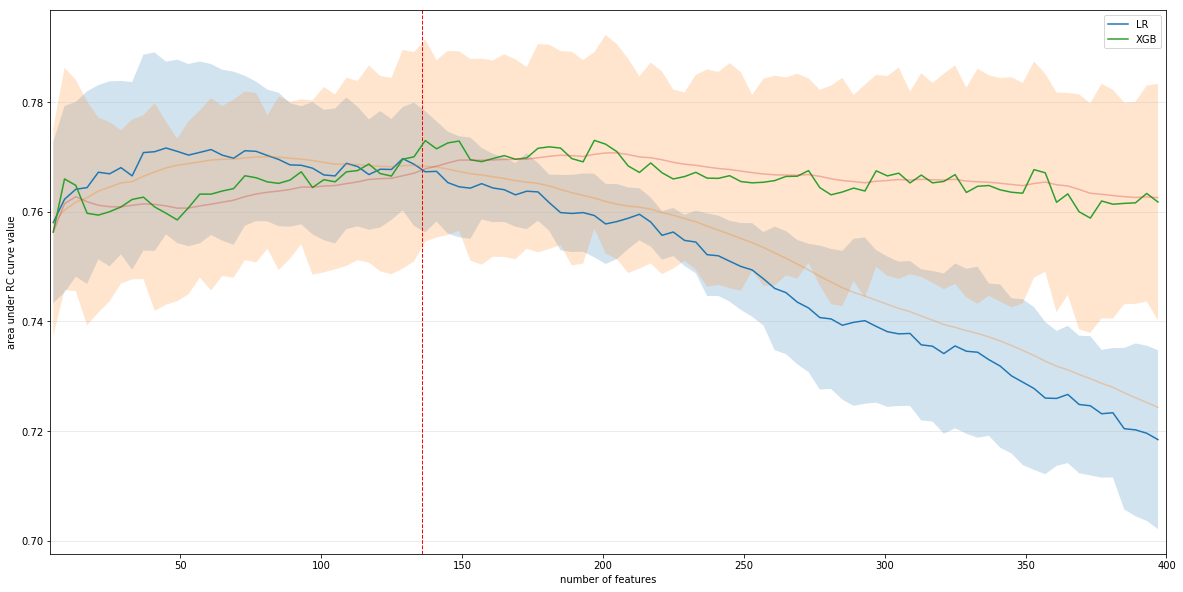

In [69]:
# compute the ewa for auc score (smoothing for trend visualization)
labels = ["LR", "XGB"]
for d in data_fs:
    d["ewa"] = d["auc"].ewm(span=14,min_periods=0,adjust=True,ignore_na=True).mean()
# create the figure
fig, ax = plt.subplots(figsize = (20,10))
ax.grid(axis='y', alpha=0.3)
plt.xlim(4,400)
plt.axvline(x=136, color='red', ls="--", lw=1)
for i,d in enumerate(data_fs):
    sns.lineplot(x="n_features", y="auc", data=d, label=labels[i])
    sns.lineplot(x="n_features", y="ewa", data=d, ls="--", alpha=0.3)
    # fill the +/- standard deviation area 
    ax.fill_between(5+d.index*4, d["auc"]-1.0*d["auc_std"], d["auc"]+1.0*d["auc_std"], 
                    alpha=0.2, interpolate=False) 
    ax.set_ylabel("area under RC curve value")
    ax.set_xlabel("number of features")
_ = plt.plot()


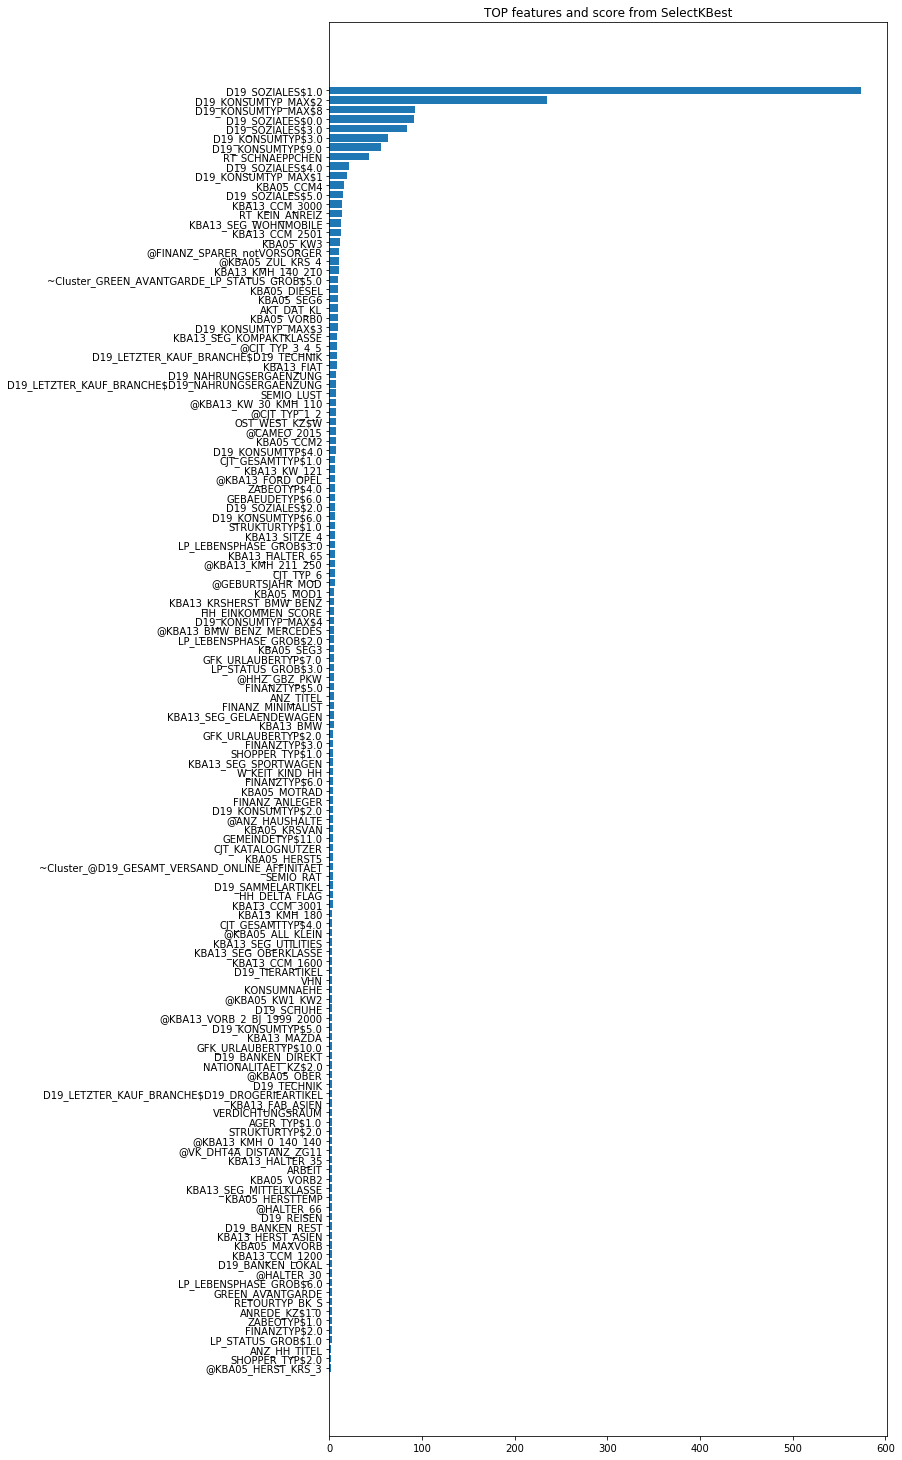

In [71]:
# I've selected 136 first features
n_features = 136
# We will keep feature names and mask for lter use
kbest_features = names[:n_features]
kbest_features_mask = np.isin(np.array(mailout_train_columns), kbest_features)

# we will now plot the feature score for all those feature
fig, ax = plt.subplots(figsize=(10,26))
plt.barh(range(n_features),values[n_features-1::-1],
         tick_label=names[n_features-1::-1])
plt.title("TOP features and score from SelectKBest")
plt.show()

In [62]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_base = LogisticRegression(C=10.0, dual=False, penalty="l2", max_iter=1400, n_jobs=-1)
scores, times = test_model(model_base, folds, mailout_train[:,kbest_features_mask], label.values)
model_base = model_base.fit(mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.770 (standard dev. 0.011) in  4.4 s. per model


In [365]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

model_base_xgb = XGBClassifier(**p_XGB0)
scores, times = test_model(model_base_xgb, folds, mailout_train[:,kbest_features_mask], label.values)
model_base_xgb = model_base_xgb.fit(mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.769 (standard dev. 0.013) in  6.7 s. per model


### 2.4 Classes balance and downsampling

In [64]:
# donut plot for class balance
def plot_classes_blance(label):
    """label: Pandas dataframe """
    
    # generate counts for each class
    data = label.value_counts()
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

    # generate te pie plot
    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    # add text annotation for each portion
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate("{:.01f}%".format(data[i]/label.shape[0]*100), 
                    xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    # add legend
    ax.legend(wedges, data.index,
              title="Response",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title("Classes balance")
    p = plt.plot()

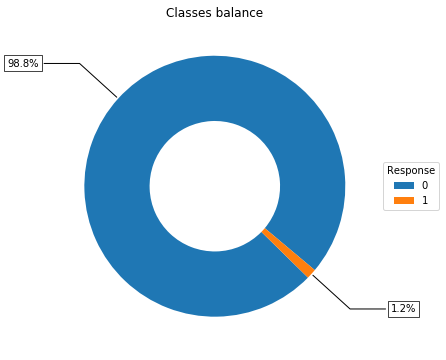

In [65]:
# plot the class balance
plot_classes_blance(label)

In [76]:
# create a downsmapling generator
# the idea is to down sample the data for train only and label 0 only
# the the test sets remains untouched and the scoring stay consistent 
class DownsampleStratifiedKFold:

    # intialization
    def __init__(self, n_splits=3, ratio=0.5, random_state=42):
        self.n_splits = n_splits
        self.ratio = ratio
        self.random_state = random_state

    # static method for downsampling (so it can be used outised of the fold generator)
    @staticmethod 
    def downsample(y, train_i, ratio):
        #downsampling is down only on label 0 for training
        train_i_label_0 = train_i[y[train_i]==0]
        train_i_label_1 = train_i[y[train_i]==1]
        np.random.shuffle(train_i_label_0)
        split_idx = int(len(train_i_label_0)*ratio)
        #downsampling
        train_i = train_i_label_0[:split_idx] 
        train_i = np.concatenate([train_i, train_i_label_1], axis=0)
        np.random.shuffle(train_i)
        return train_i
        
    # split method as in the sklearn generator
    def split(self, X, y, groups=None):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True,
                                random_state=self.random_state)
        for train_i, eval_i in cv.split(X,y):
            train_i = self.downsample(y, train_i, self.ratio)
            yield train_i, eval_i

    # get_n_splits method as in the sklearn generator
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [67]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = DownsampleStratifiedKFold(n_splits=n_splits, ratio=1.0)

model_xgb_down = XGBClassifier(**p_XGB0)
scores, times = test_model(model_xgb_down, folds, mailout_train[:,kbest_features_mask], label.values)
model_xgb_down = model_xgb_down.fit(mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.769 (standard dev. 0.013) in  2.5 s. per model


In [79]:
n_try = 4 

data = [pd.DataFrame(columns=["ratio","iteration","try","score","time"])] * 3
X = mailout_train[:,kbest_features_mask]
y = label.values

for ratio_pct in range(100,0,-1):
    start_time = time.time()
    print(ratio_pct, end="")
    for try_i in range(n_try):
        print(".",end="")
        models = [LogisticRegression(C=10.0, dual=False, penalty="l2", max_iter=1400, n_jobs=-1), 
                  XGBClassifier(**p_XGB0)]
        for m_i,m in enumerate(models):
            m = clone(m)
            np.random.seed(10+j)
            folds = DownsampleStratifiedKFold(n_splits=n_splits, ratio=ratio_pct/100)
            scores, times = test_model(m, folds, X, y, verbose=False)
            for s_i,e in enumerate(scores): 
                data[m_i] = data[m_i].append({"ratio":ratio_pct/100, "iteration":s_i, "try":try_i, 
                                        "score":e, "time":times[s_i]}, ignore_index=True)

    if (ratio_pct-1)%20==0 : print()


100....99....98....97....96....95....94....93....92....91....90....89....88....87....86....85....84....83....82....81....
80....79....78....77....76....75....74....73....72....71....70....69....68....67....66....65....64....63....62....61....
60....59....58....57....56....55....54....53....52....51....50....49....48....47....46....45....44....43....42....41....
40....39....38....37....36....35....34....33....32....31....30....29....28....27....26....25....24....23....22....21....
20....19....18....17....16....15....14....13....12....11....10....9....8....7....6....5....4....3....2....1....


In [80]:
downsampling_ratio = 0.44

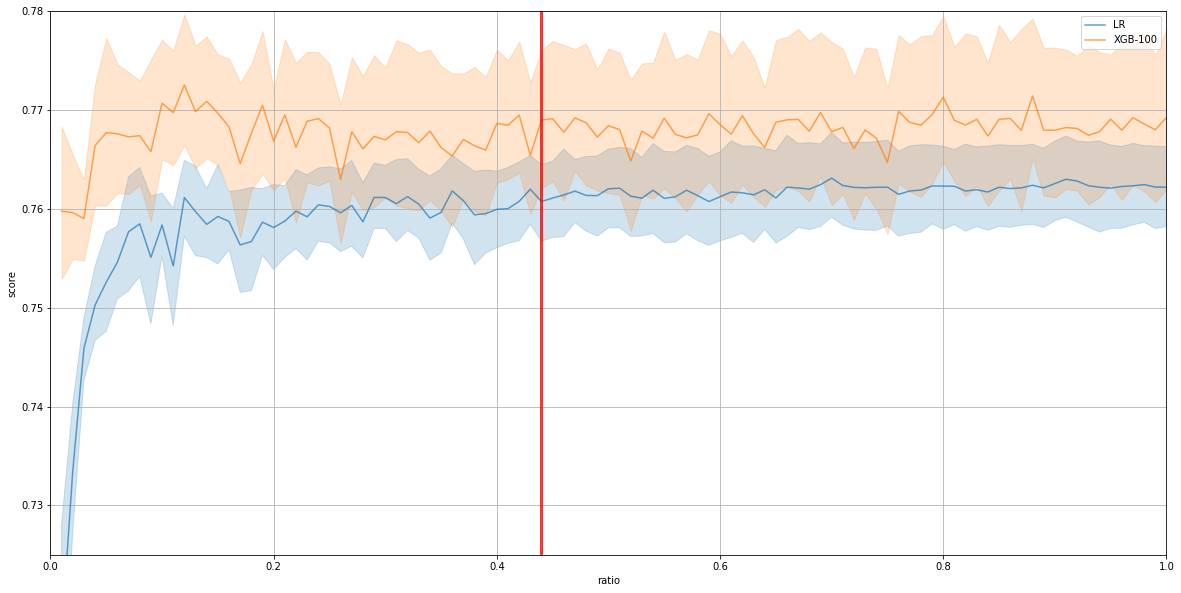

In [81]:
fig, ax = plt.subplots(figsize = (20,10))
labels = ["LR", "XGB-100"]
for i,_ in enumerate(labels):
    d = data[i] 
    sns.lineplot(x="ratio", y="score", data=d, alpha=0.7, label=labels[i])
plt.ylim(0.725,0.78)
plt.xlim(0,1)
ax.grid()
plt.axvline(x=downsampling_ratio, color='red',ls="-",lw=3, alpha=0.8)
_ = plt.plot()


In [410]:
## Create sets generator for cross validation
np.random.seed(1974)
folds = DownsampleStratifiedKFold(n_splits=n_splits, ratio=downsampling_ratio)
## Base model with standard parameters and feature selection 
model_base_down = LogisticRegression(C=10.0, dual=False, penalty="l2", max_iter=1400, n_jobs=-1)
scores, times = test_model(model_base_down, folds, mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.764 (standard dev. 0.007) in  1.8 s. per model


In [411]:
np.random.seed(1974)
train_i = np.array([i for i in range(mailout_train.shape[0])])
train_i = DownsampleStratifiedKFold.downsample(label.values, train_i, downsampling_ratio)
X = mailout_train[train_i,:][:,kbest_features_mask]
y = label.values[train_i]
model_base_down = model_base_down.fit(X, y)

In [412]:
# Create the generator, the model and score the model
np.random.seed(1974)
folds = DownsampleStratifiedKFold(n_splits=n_splits, ratio=downsampling_ratio)
model_xgb_down = XGBClassifier(**p_XGB0)
scores, times = test_model(model_xgb_down, folds, mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.763 (standard dev. 0.015) in  3.0 s. per model


In [413]:
np.random.seed(1974)
train_i = np.array([i for i in range(mailout_train.shape[0])])
train_i = DownsampleStratifiedKFold.downsample(label.values, train_i, downsampling_ratio)
X = mailout_train[train_i,:][:,kbest_features_mask]
y = label.values[train_i]
model_xgb_down = model_xgb_down.fit(X, y)

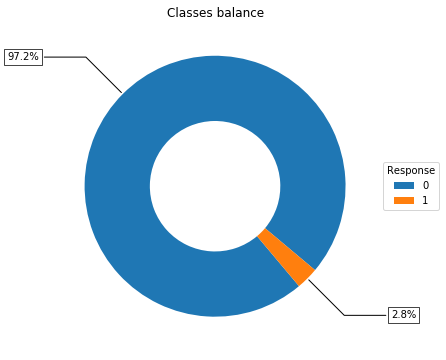

In [73]:
# plot the class balance after down-sampling
plot_classes_blance(label.iloc[train_i])

### 2.5 XGBoost (hyperparameters grid search)

In [74]:
XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [414]:
param_grid = {}
param_grid["seed"]              =[42]
param_grid["n_jobs"]            =[-1]
param_grid["random_state"]      =[42]
param_grid["verbosity"]         =[0]

param_grid["objective"]         =["binary:logistic"] 
param_grid["eval_metric"]       =["auc"] 

param_grid["booster"]           =["gbtree"]

param_grid["n_estimators"]      =[110]
param_grid["learning_rate"]     =[0.05] 
param_grid["max_depth"]         =[4]

param_grid["colsample_bylevel"] =[1]
param_grid["colsample_bynode"]  =[0.95]
param_grid["colsample_bytree"]  =[0.95]
param_grid["subsample"]         =[0.95]

param_grid["scale_pos_weight"]  =[2]
param_grid["min_child_weight"]  =[2]

param_grid["gamma"]             =[1]
param_grid["reg_alpha"]         =[0.1] 
param_grid["reg_lambda"]        =[0.9]

param_grid["max_delta_step"]    =[0] 
param_grid["base_score"]        =[0.5]

np.random.seed(1988)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_xgb = XGBClassifier()

# ## Perform the grid search over the parameters
clf = GridSearchCV(estimator=model_xgb, param_grid=param_grid, 
                      cv=folds, scoring="roc_auc", n_jobs=-1, 
                      return_train_score=True, verbose=1)

X = mailout_train[:,kbest_features_mask]
y = label.values
clf.fit(X,y)
p_XGB = clf.best_estimator_.get_params()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


In [415]:
p_XGB # best parameters set found

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 0.95,
 'colsample_bytree': 0.95,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 2,
 'missing': None,
 'n_estimators': 110,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_alpha': 0.1,
 'reg_lambda': 0.9,
 'scale_pos_weight': 2,
 'seed': 42,
 'silent': None,
 'subsample': 0.95,
 'verbosity': 0,
 'eval_metric': 'auc'}

In [416]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_xgb = XGBClassifier(**p_XGB)
scores, times = test_model(model_xgb, folds, mailout_train[:,kbest_features_mask], label.values)
model_xgb = model_xgb.fit(mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.764 (standard dev. 0.024) in  9.9 s. per model


### 2.6 CatBoost

In [78]:
CatBoostClassifier()

In [392]:
param_grid = {}
param_grid["verbose"]             = [False]
# param_grid["task_type"]           = ["GPU"]
param_grid["loss_function"]       = ["Logloss"]
param_grid["eval_metric"]         = ["AUC"]

param_grid["grow_policy"]         = ["SymmetricTree"]

param_grid["learning_rate"]       = [0.05]
param_grid["iterations"]          = [350] 
param_grid["depth"]               = [2] 

param_grid["scale_pos_weight"]    = [3]

param_grid["l2_leaf_reg"]         = [0.2] # [4.0,5.0,6.0] [2.0,3.0,4.0]
param_grid["random_strength"]     = [3.0] # [3.0,4.0,5.0] [1.0,2.0,3.0]
param_grid["bagging_temperature"] = [0.0] # [0.0,1.0,2.0]

np.random.seed(1988)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_catb = CatBoostClassifier()

# ## Perform the grid search over the parameters
clf = GridSearchCV(estimator=model_catb, param_grid=param_grid, 
                      cv=folds, scoring='roc_auc', n_jobs=-1, 
                      return_train_score=True, verbose=1)
X = mailout_train[:,kbest_features_mask]
y = label.values
clf.fit(X,y)
p_CatB = clf.best_estimator_.get_params()

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   51.5s finished


In [395]:
p_CatB # best parameters set found

{'grow_policy': 'SymmetricTree',
 'scale_pos_weight': 3,
 'bagging_temperature': 0.0,
 'eval_metric': 'AUC',
 'random_strength': 3.0,
 'verbose': False,
 'loss_function': 'Logloss',
 'l2_leaf_reg': 0.2,
 'depth': 2,
 'learning_rate': 0.05,
 'iterations': 350}

In [397]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_catb = CatBoostClassifier(**p_CatB)
scores, times = test_model(model_catb, folds, mailout_train[:,kbest_features_mask], label.values)
model_catb = model_catb.fit(mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.778 (standard dev. 0.017) in  3.4 s. per model


### 2.7 Light GBM

In [82]:
LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [336]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

param_grid = {}
param_grid["objective"]             = ["binary"]
param_grid["seed"]                  = [42]
param_grid["metric"]                = ["auc"]
param_grid["boosting_type"]         = ["gbdt"]
param_grid["n_estimators"]          = [16]
param_grid["learning_rate"]         = [0.10]
param_grid["max_depth"]             = [4]
param_grid["num_leaves"]            = [12]
# param_grid["bagging_fraction"]      = [0.5] 
 
param_grid["min_child_weight"]      = [1e-11]
param_grid["min_split_gain"]        = [0]
param_grid["min_child_samples"]     = [21]       
param_grid["subsample_for_bin"]     = [2000000000]
param_grid["subsample"]             = [1.0]
param_grid["subsample_freq"]        = [0]
param_grid["colsample_bytree"]      = [1.0]

param_grid["reg_alpha"]             = [0]
param_grid["reg_lambda"]            = [0.001]
# param_grid["class_weight"]          = [None, (label.values*0.04)+0.48]

param_grid["importance_type"]       = ["gain"]

np.random.seed(1988)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_lgbm = LGBMClassifier()

# ## Perform the grid search over the parameters
clf = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, 
                      cv=folds, scoring='roc_auc', n_jobs=-1, 
                      return_train_score=True, verbose=1)
clf.fit(mailout_train[:,kbest_features_mask], label.values)
p_LGbm = clf.best_estimator_.get_params()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


In [337]:
p_LGbm # best parameters set found 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_samples': 21,
 'min_child_weight': 1e-11,
 'min_split_gain': 0,
 'n_estimators': 16,
 'n_jobs': -1,
 'num_leaves': 12,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0,
 'reg_lambda': 0.001,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 2000000000,
 'subsample_freq': 0,
 'metric': 'auc',
 'seed': 42}

In [351]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

model_lgbm = LGBMClassifier(**p_LGbm)
scores, times = test_model(model_lgbm, folds, mailout_train[:,kbest_features_mask], label.values)
model_lgbm = model_lgbm.fit(mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.768 (standard dev. 0.018) in  0.7 s. per model


### 2.8 TPot (Auto-ML using genetic programming)

In [462]:
# create the folds generator
np.random.seed(1988)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)

# instanciante the TPot classifier
# TPot wil generate a intial population 
# then refresh and make mutation in the population 
# I've specified a folder where TPot will store the best models found at each generation
# it is interesting to look at what is investigated 
# warm start allows to restart the fit without loosing all the work done so far 
# very useful in case of crash but also when you work on your own laptop... 
model_tpot = tpot.TPOTClassifier(scoring="roc_auc", 
                            verbosity=2, 
                            population_size=200,
                            offspring_size=100,
                            warm_start=True,
                            generations=100,
                            cv=folds,
                            n_jobs=-1,
                            periodic_checkpoint_folder="tpot")

In [ ]:
# the model is fitted like a standard sklearn model
# except it can last several days
model_tpot.fit(mailout_train[:,kbest_features_mask], label.values)

Generation 1 - Current best internal CV score: 0.7726012582966216
Generation 2 - Current best internal CV score: 0.7765258153574843


In [464]:
# export the winning model definition
model_tpot.export('tpot_pipeline.py')

In [72]:
!pygmentize tpot_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.7724976335144802
exported_pipeline = ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.6500000000000001, min_samples_leaf=16, min_samples_split=15, n_estimators=100)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [398]:
# Create the generator, the model, score the model and perform the final fit
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)
# Average CV score on the training set was: 0.7734925756335089
model_tpot = ExtraTreesClassifier(bootstrap=True, criterion="gini", max_features=0.55, 
                                  min_samples_leaf=15, min_samples_split=7, n_estimators=100)
scores, times = test_model(model_tpot, folds, mailout_train[:,kbest_features_mask], label.values)
model_tpot = model_tpot.fit(mailout_train[:,kbest_features_mask], label.values)

Mean area under ROC curve : 0.771 (standard dev. 0.011) in  9.7 s. per model


### 2.8 Ensemble by stacking models

In [454]:
# inspired by https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

class StackedModels(BaseEstimator, RegressorMixin, TransformerMixin):

    def __init__(self, base_models, meta_model, cv=StratifiedKFold(n_splits=5)):
        self.base_models = base_models
        self.cv = cv
        self.n_folds =cv.n_splits
        self.__meta_model = meta_model
        self.__models = [[None]*(len(self.base_models))]*self.n_folds
        self.__scores = [[-999]*(len(self.base_models))]*self.n_folds

    # build and fit all the models : base models, meta model
    def fit(self, X, y, verbose=False):
        self.__meta_model  = clone(self.__meta_model)
        
        # where we store our intermediary predition
        stacked_y = np.zeros((X.shape[0], (len(self.base_models))))
        model_name = ""
        
        # Train all models on folds
        # keep the eval prediction for the meta model
        for bmodel_idx in range(len(self.base_models)):
            score_total = 0.0
            for i, (train_index, eval_index) in enumerate(self.cv.split(X, y)):
                X_train, X_eval = X[train_index], X[eval_index]
                y_train, y_eval = y[train_index], y[eval_index]
                m = clone(self.base_models[bmodel_idx])
                m.fit(X_train, y_train)
                self.__models[i][bmodel_idx] = m
                y_out = m.predict_proba(X_eval)[:,1]
                stacked_y[eval_index, bmodel_idx] = y_out.ravel()
                score = roc_auc_score((y_eval), (y_out))
                self.__scores[i][bmodel_idx] = score 
                score_total = score_total + score
                if verbose : 
                    if type(m) != model_name : 
                        model_name = type(m)
                        print(model_name)
                    print(i, score)
            if verbose : print("...avg", score_total/self.n_folds)
            
        # fit the meta model using all the eval prediction 
        self.__meta_model.fit(stacked_y, y)
        if verbose :
            print(type(self.__meta_model))
            print([e for e in self.__meta_model.named_steps.keys()])
            if "lasso" in self.__meta_model.named_steps.keys():
                print(self.__meta_model["lasso"].coef_)
            if "logisticregression" in self.__meta_model.named_steps.keys():
                print(self.__meta_model["logisticregression"].coef_)
            print(np.mean(self.__scores), np.std(self.__scores))

        return self
   
    # perform the probability prediction for X
    def predict_proba(self, X):
        stacked_pred = np.zeros((X.shape[0], (len(self.base_models))))
        # adding the prediction for each fold
        for i in range(self.n_folds):
            for j in range(len(self.base_models)):
                p = self.__models[i][j].predict_proba(X)[:,1]
                stacked_pred[:,j] = stacked_pred[:,j]+p
        # averaging for each model
        stacked_pred = stacked_pred / self.n_folds

        # lastly use the meta model 
        return self.__meta_model.predict_proba(stacked_pred) 

In [427]:
#creates all the models 
model_meta = make_pipeline(LogisticRegression(penalty="l2", random_state=1))

m0 = LogisticRegression(C=10.0, dual=False, penalty="l2", max_iter=1400, n_jobs=-1)
m1 = XGBClassifier(**p_XGB)
m2 = CatBoostClassifier(**p_CatB)
m3 = LGBMClassifier(**p_LGbm)
m4 = ExtraTreesClassifier(bootstrap=True, criterion="gini", max_features=0.55, 
                                  min_samples_leaf=15, min_samples_split=7, n_estimators=100)

# create the folding, the stacked models model and fits it
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
model_stk = StackedModels((m0, m1, m2, m3, m4), 
                          meta_model=model_meta, cv=folds)
model_stk = model_stk.fit(mailout_train[:,kbest_features_mask], label.values, verbose=True)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
0 0.7684817874850496
1 0.7764751619489825
2 0.7569348405142322
3 0.7583939585288089
4 0.7669557851111042
...avg 0.7654483067176356
<class 'xgboost.sklearn.XGBClassifier'>
0 0.7462009995572698
1 0.7963793031292882
2 0.7590515343807115
3 0.7551522151912806
4 0.7539020984618395
...avg 0.762137230144078
<class 'catboost.core.CatBoostClassifier'>
0 0.7652020590263018
1 0.8121887396723796
2 0.7567352887552862
3 0.7669307716594257
4 0.7850043801333162
...avg 0.7772122478493418
<class 'lightgbm.sklearn.LGBMClassifier'>
0 0.7471773189926894
1 0.7983660828940906
2 0.7579198146558817
3 0.7625095051116378
4 0.7504424601674679
...avg 0.7632830363643535
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
0 0.7528970200506166
1 0.7900940746826548
2 0.7667345550273703
3 0.7586079625042801
4 0.776379186140102
...avg 0.7689425596810049
<class 'sklearn.pipeline.Pipeline'>
['logisticregression']
[[2.76959766 4.60923459 7.55410466 1.46041547 3

In [458]:
np.random.seed(1974)
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)
model_stk = StackedModels((m0v0, m1v1, m2v1, m3v1, m4v1), 
                          meta_model=model_meta, cv=folds)
scores, times = test_model(model_stk, folds, mailout_train[:,kbest_features_mask], label.values)
model_stk = model_stk.fit(mailout_train[:,kbest_features_mask], label.values, verbose=False)

Mean area under ROC curve : 0.778 (standard dev. 0.015) in 108.0 s. per model


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [97]:
df_mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
lines = df_mailout_test.LNR
print(df_mailout_test.shape)

#check duplicates
cols_duplicates = list(df_mailout_test.columns)
cols_duplicates.remove("LNR")
print("Number of duplicated", df_mailout_test.duplicated(subset=cols_duplicates).sum())

# remove columns as for the azdias dataset
for c in cols_na: 
    if c in df_mailout_test.columns: 
        df_mailout_test.drop(columns=[c], inplace=True)

df_mailout_test.shape, lines.shape

(42833, 366)


((42833, 364), (42833,))

In [105]:
# prepare the data from the mail train datast
df_mailout_test = h.data_preparation(df_mailout_test)
# add missing columns if any
missing_cols = [c for c in azdias_columns if c not in df_mailout_test.columns]
missing_cols = missing_cols + [c for c in customers_columns if c not in df_mailout_test.columns]
missing_cols = list(set(missing_cols))
for c in missing_cols:
    print(c)
    df_mailout_test[c] = np.nan
print(df_mailout_train.shape)

(42833, 364)
drop
..........! (42833, 357)
correct
.......! (42833, 357)
correct values
.....! (42833, 357)
convert nan values to nan
................................................................................................................................................................................................................................................................! (42833, 357)
duplicate
....! (42833, 361)
map
...........................................................! (42833, 361)
cat encoding
..............................! (42833, 498)
reverse order
! (42833, 498)
combine features
..............................................! (42833, 422)
drop
.........! (42833, 413)
TITEL_KZ$2.0
GEBAEUDETYP$5.0
(42962, 431)


((42833, 415), (42833, 123))

In [106]:
# calculate PCA for clustering
mailout_test_pca = transformer.transform(df_mailout_test.values)
mailout_test_pca = imputer.transform(mailout_test_pca)
mailout_test_pca = pca.transform(mailout_test_pca)

# find the clusters for each mail test prospect 
clusters_mailout_test = clustering.predict(mailout_test_pca)

#perform one-hot encoding to add the custer number to the dataframe
clusters_mailout_test_data = one_hot_enc.transform(clusters_mailout_test.reshape(-1,1))

for i in range(n_clusters):
    df_mailout_test["~Cluster_"+seg_names[i]] = clusters_mailout_test_data[:,i]
df_mailout_test.shape

(42833, 423)

In [107]:
# compute distance to centroids and add them to the dataframe
for i,center in enumerate(clustering.cluster_centers_):
    distance = np.sqrt((mailout_test_pca-center)**2).sum(axis=1)
    df_mailout_test["~Distance_"+seg_names[i]] = distance.reshape(-1,1)

mailout_test_columns = list(df_mailout_test.columns)
df_mailout_test.shape    

(42833, 431)

In [110]:
#apply scaler and imputation
mailout_test = scaler_mail.transform(df_mailout_test.values)
mailout_test = imputer_mail.transform(mailout_test)
mailout_test.shape, np.min(mailout_test), np.mean(mailout_test), np.max(mailout_test) 

((42833, 429), -34.79441197674574, 0.0006336935412927408, 92.68980526465677)

In [112]:
#apply local PCA on a copy
mailout_test_pca_mail = pca_mail.transform(mailout_test)
mailout_test_pca_mail.shape

In [ ]:
# Get a model instance, a model name, a X 
# Generate the submission file or the model 
def create_submission_file(model, model_str, X):
    start_time = time.time()
    print(model_str, end="\r")
    preds = model.predict_proba(X)[:,1]
    df=pd.DataFrame()
    df["LNR"] = lines
    df["RESPONSE"] = preds
    df.to_csv("submission_"+str(model_str)+".csv", index=False, header=True)
    print(" {:2.03f} {}".format(time.time()-start_time, model_str) )

In [461]:
#create a submission file for each model create
create_submission_file(model_base_0,         "model_base_0",         mailout_test[:,])
create_submission_file(model_base_0_pca,     "model_base_0_pca",     mailout_test_pca_mail[:,])
create_submission_file(model_base,           "model_base",           mailout_test[:,kbest_features_mask])
create_submission_file(model_base_down,      "model_base_down",      mailout_test[:,kbest_features_mask])
create_submission_file(model_base_xgb_0,     "model_base_xgb_0",     mailout_test[:,])
create_submission_file(model_base_xgb_0_pca, "model_base_xgb_0_pca", mailout_test_pca_mail[:,])
create_submission_file(model_base_xgb,       "model_base_xgb",       mailout_test[:,kbest_features_mask])
create_submission_file(model_xgb_down,       "model_xgb_down",       mailout_test[:,kbest_features_mask])
create_submission_file(model_xgb,            "model_xgb",            mailout_test[:,kbest_features_mask]) 
create_submission_file(model_catb,           "model_catb",           mailout_test[:,kbest_features_mask])
create_submission_file(model_lgbm,           "model_lgbm",           mailout_test[:,kbest_features_mask])
create_submission_file(model_tpot,           "model_tpot",           mailout_test[:,kbest_features_mask])
create_submission_file(model_stk,            "model_stk",            mailout_test[:,kbest_features_mask])
create_submission_file(model_stk2,           "model_stk2",           mailout_test[:,kbest_features_mask])

model_base_0. 0.15146994590759277
model_base_0_pca. 0.14413166046142578
model_base. 0.13689279556274414
model_base_down. 0.13962793350219727
model_base_xgb_0. 0.3563110828399658
model_base_xgb_0_pca. 0.2660081386566162
model_base_xgb. 0.23715829849243164
model_xgb_down. 0.24320197105407715
model_xgb. 0.2732737064361572
model_catb. 0.13984155654907227
model_lgbm. 0.20477032661437988
model_tpot. 0.5825977325439453
model_stk. 3.490204095840454
model_stk2. 0.8251886367797852
